R squared value: 0.9929445030252421
Accuracy score: 0.5082872928176796
              precision    recall  f1-score   support

           0       0.45      0.50      0.48       161
           1       0.56      0.51      0.54       201

    accuracy                           0.51       362
   macro avg       0.51      0.51      0.51       362
weighted avg       0.51      0.51      0.51       362



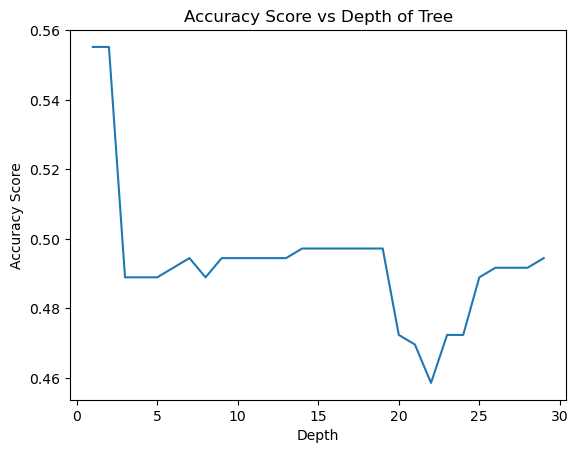

Best tree accuracy (depth=1): 0.5552486187845304
              precision    recall  f1-score   support

           0       0.50      0.08      0.14       161
           1       0.56      0.94      0.70       201

    accuracy                           0.56       362
   macro avg       0.53      0.51      0.42       362
weighted avg       0.53      0.56      0.45       362



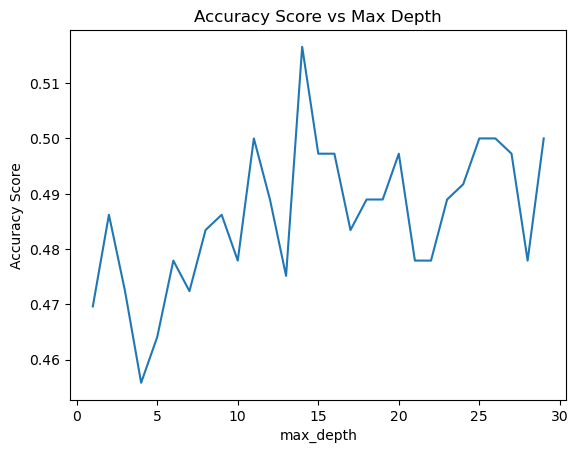

Best random forest accuracy (max_depth=14): 0.5165745856353591
              precision    recall  f1-score   support

           0       0.47      0.68      0.56       161
           1       0.60      0.38      0.47       201

    accuracy                           0.52       362
   macro avg       0.54      0.53      0.51       362
weighted avg       0.54      0.52      0.51       362



In [ ]:
#COSC Midterm code submission 
#Adison White, Brandon Bull, Buck Arthur
#10/30/2024

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, r2_score, classification_report
from sklearn.ensemble import RandomForestClassifier


##########################################################
#Additional analysis

# Takes in src_arr, takes its src_col and shifts it shift rows (in our dataset, it's how many days it will be shifted)
# It will then delete shift+remove rows from the set
#
# So it returns an array that is size(rows-shift, columns+1)
#
# the fact it's 3 lines kills me
def append_column_and_shift(src_arr, src_col, shift, remove=0):
    
    # Gets the column and rows before shift rows from the end (effectively deleting those elements)
    new_col = src_arr[:shift*-1,src_col]
    
    # Delete first rows of array
    int_arr = src_arr[shift:,:]

    # Adds the new column to the array
    new_arr = np.append(int_arr, new_col[:, np.newaxis], axis=1)

    if remove > 0:
        return new_arr[:-1*remove]
    
    return new_arr

# Does basically what's above but just returns one column (for y)
def get_y_data(src_arr, src_col, shift, remove):
    ret_col = src_arr[shift:,src_col]

    ret_col = ret_col[remove:]
        
    return ret_col

##########################################################
#initial feature and label setup

data = pd.read_csv('berkshire_hathaway_data.csv')

#All given features
X_0 = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].values

# Parameters
day = 1         # Days in future to test
y_col = 3       # Which feature to use (Close = 3)
column = 3      # Which feature to duplicate (Close = 3)
length = 14      # How many prev days to include for dataset

# Transform data
X = X_0
if length > 0:
    X = append_column_and_shift(X, column, 1, day)
    for i in range(1, length):
        X = append_column_and_shift(X, len(X[0])-1, 1, 0)

y_raw = get_y_data(X_0, y_col, day, length)[:,np.newaxis]

##########################################################
#Linear regression using given features

split_point = 2000
X_train = X[:split_point]
X_test = X[split_point:]
y_train = y_raw[:split_point]
y_test = y_raw[split_point:]


#turn y_test from float value to binary classification (1 = increase)
y_test_clas = []
for i in range(0, len(y_test)):
    if (y_test[i] > X_test[i][4]): y_test_clas.append(1)
    else: y_test_clas.append(0)

#train and predict
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)
y_linreg_float = lin_reg_model.predict(X_test)

# Pickle model
joblib.dump(lin_reg_model, './lin_reg_model.pkl')

#evaluate
r2_linreg = r2_score(y_test, y_linreg_float)
print(f'R squared value: {r2_linreg}')

#make predictions classification
y_linreg = []
for i in range(0, len(y_linreg_float)):
    if (y_linreg_float[i] > X_test[i][4]): y_linreg.append(1)
    else: y_linreg.append(0)

print(f'Accuracy score: {accuracy_score(y_test_clas, y_linreg)}')
print(classification_report(y_test_clas, y_linreg))

##########################################################
#Binary trees with more features
X = np.ndarray((X_0.shape[0], 3))

#change X array
for i in range (0, X_0.shape[0]):
    #Range
    X[i, 0] = X_0[i, 1] - X_0[i, 2]
    #Volume
    X[i, 1] = X_0[i, 5]
    #Change
    X[i, 2] = X_0[i, 0] - X_0[i, 4]

#turn y_train from float value to binary classification (1 = increase)
y_train_clas = []
for i in range(0, len(y_train)):
    if (y_train[i] > X_train[i][4]): y_train_clas.append(1)
    else: y_train_clas.append(0)

#single tree: experiment with various depths
accuracies = []
depths = []
for i in range (1, 30):
    dtree = DecisionTreeClassifier(max_depth = i, random_state = 325)
    dtree.fit(X_train, y_train_clas)
    yh = dtree.predict(X_test)
    a = accuracy_score(y_test_clas, yh)
    accuracies.append(a)
    depths.append(i)
plt.plot(depths, accuracies)
plt.xlabel("Depth")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Score vs Depth of Tree")
plt.show()

best_depth = accuracies.index(max(accuracies)) + 1

#best tree
tree = DecisionTreeClassifier(max_depth = best_depth, random_state=325)
tree.fit(X_train, y_train_clas)
#plot_tree(tree)
y_tree = tree.predict(X_test)
acc = accuracy_score(y_test_clas, y_tree)
print(f'Best tree accuracy (depth={best_depth}): {acc}')
print(classification_report(y_test_clas, y_tree))

#Random forest: try different max depths
accuracies = []
depths = []
for i in range (1, 30):
    dforest = RandomForestClassifier(n_estimators = 100, max_depth = i, random_state = 325)
    dforest.fit(X_train, y_train_clas)
    yh = dforest.predict(X_test)
    a = accuracy_score(y_test_clas, yh)
    accuracies.append(a)
    depths.append(i)
plt.plot(depths, accuracies)
plt.xlabel("max_depth")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Score vs Max Depth")
plt.show()
best_depth = accuracies.index(max(accuracies)) + 1

#Best random forest
forest = RandomForestClassifier(n_estimators = 100, max_depth = best_depth, random_state = 325)
forest.fit(X_train, y_train_clas)
y_hat_f = forest.predict(X_test)
acc_f = accuracy_score(y_test_clas, y_hat_f)
print(f'Best random forest accuracy (max_depth={best_depth}): {acc_f}')
print(classification_report(y_test_clas, y_hat_f))


